# Training Predictive Model - Eyes Edition

### Import libraries

In [ ]:
import datetime, json, random, IPython, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torch, pytorch_lightning as pl
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger

from models import GazeDataModule, SingleModel, EyesModel, FullModel
from utils  import (
    get_config,
    tune_asha,
    get_best_results,
    save_model,
    plot_asha_param_grid,
    plot_parallel_param_loss,
    latest_tune_dir,
    _build_datamodule,
    _build_model,
    predict_screen_errors,
)

# project settings
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload
%autoreload 2


### Dataset information

In [2]:
df = pd.read_csv("data/positions.csv")
region_map = np.load("data/region_map.npy").T

print(f"# of samples: {len(df)}")
coverage = np.count_nonzero(region_map > 0) / region_map.size * 100
print(f"Coverage: {coverage:.2f}% of screen surface")
print(f"Crop size: {SETTINGS['image_size']} x {SETTINGS['image_size']} px")

# of samples: 20077
Coverage: 61.84% of screen surface
Crop size: 64 x 64 px


### Fine tuning

In [ ]:
search_space = {
    "seed":  tune.randint(0, 10000),
    "bs":    tune.choice([128, 256, 512]),
    "lr":    tune.loguniform(1e-4, 3e-3),
    "channels": tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "hidden":   tune.choice([128, 256, 512]),
}

analysis = tune_asha(
    search_space   = search_space,
    train_func     = "eyes",
    name           = "eyes/tune",
    img_types      = ["l_eye", "r_eye"],
    num_samples    = 20,
    num_epochs     = 15,
    data_dir     = Path.cwd() / "data",
    seed           = 87,
)

2025-05-13 20:14:11,458	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-13 20:14:15,012	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-05-13 20:14:15,012	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_tune_wrapper pid=24264) Seed set to 1935
(_tune_wrapper pid=24264) Using bfloat16 Automatic Mixed Precision (AMP)
(_tune_wrapper pid=24264) GPU available: True (cuda), used: True
(_tune_wrapper pid=24264) TPU available: False, using: 0 TPU cores
(_tune_wrapper pid=24264) HPU available: False, using: 0 HPUs
(_tune_wrapper pid=24264) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_tune_wrapper pid=24264) 
(_tune_wrapper pid=24264)   | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
(_tune_wrapper pid=24264) ------------------------------------------------------------------------------------------
(_tune_wrapper pid=24264) 0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
(_tune_wrapper pid=24264) 1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
(_tune_wrapper pid=24264) 2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
(_tune_wrapper pid=24264) 3 | rmse

Trial name,checkpoint_dir_name,date,done,hostname,iterations_since_restore,loss,mae,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
_tune_wrapper_13f5f_00000,checkpoint_000014,2025-05-13_20-30-08,True,DESKTOP-B40NR52,15,316.489,316.988,127.0.0.1,24264,True,942.894,57.4699,942.894,1747161008,15,13f5f_00000
_tune_wrapper_13f5f_00001,checkpoint_000014,2025-05-13_20-47-39,True,DESKTOP-B40NR52,15,100.063,100.561,127.0.0.1,22632,True,1036.17,63.361,1036.17,1747162059,15,13f5f_00001
_tune_wrapper_13f5f_00002,checkpoint_000014,2025-05-13_21-06-23,True,DESKTOP-B40NR52,15,83.113,83.6112,127.0.0.1,23488,True,1110.32,65.5539,1110.32,1747163183,15,13f5f_00002
_tune_wrapper_13f5f_00003,checkpoint_000003,2025-05-13_21-11-14,True,DESKTOP-B40NR52,4,251.582,252.082,127.0.0.1,16536,True,280.499,42.4641,280.499,1747163474,4,13f5f_00003
_tune_wrapper_13f5f_00004,checkpoint_000000,2025-05-13_21-14-14,True,DESKTOP-B40NR52,1,751.535,752.035,127.0.0.1,15128,True,169.8,169.8,169.8,1747163654,1,13f5f_00004
_tune_wrapper_13f5f_00005,checkpoint_000001,2025-05-13_21-18-41,True,DESKTOP-B40NR52,2,375.769,376.269,127.0.0.1,9272,True,256.169,72.9904,256.169,1747163921,2,13f5f_00005
_tune_wrapper_13f5f_00006,checkpoint_000003,2025-05-13_21-23-46,True,DESKTOP-B40NR52,4,257.659,258.159,127.0.0.1,13212,True,293.441,45.5873,293.441,1747164226,4,13f5f_00006
_tune_wrapper_13f5f_00007,checkpoint_000000,2025-05-13_21-26-58,True,DESKTOP-B40NR52,1,720.85,721.35,127.0.0.1,22956,True,180.855,180.855,180.855,1747164418,1,13f5f_00007
_tune_wrapper_13f5f_00008,checkpoint_000000,2025-05-13_21-29-40,True,DESKTOP-B40NR52,1,660.056,660.555,127.0.0.1,15984,True,151.456,151.456,151.456,1747164580,1,13f5f_00008
_tune_wrapper_13f5f_00009,checkpoint_000003,2025-05-13_21-34-31,True,DESKTOP-B40NR52,4,259.116,259.615,127.0.0.1,17400,True,280.329,42.7699,280.329,1747164871,4,13f5f_00009


(_tune_wrapper pid=24264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/eyes/tune_20250513-201407/13f5f_00000/checkpoint_000001)
(_tune_wrapper pid=24264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/eyes/tune_20250513-201407/13f5f_00000/checkpoint_000002)
(_tune_wrapper pid=24264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/eyes/tune_20250513-201407/13f5f_00000/checkpoint_000003)
(_tune_wrapper pid=24264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/eyes/tune_20250513-201407/13f5f_00000/checkpoint_000004)
(_tune_wrapper pid=24264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/s

Best hyperparameters:  {'seed': 7131, 'bs': 256, 'lr': 0.001325325433761898, 'channels': (64, 128, 256), 'hidden': 512}


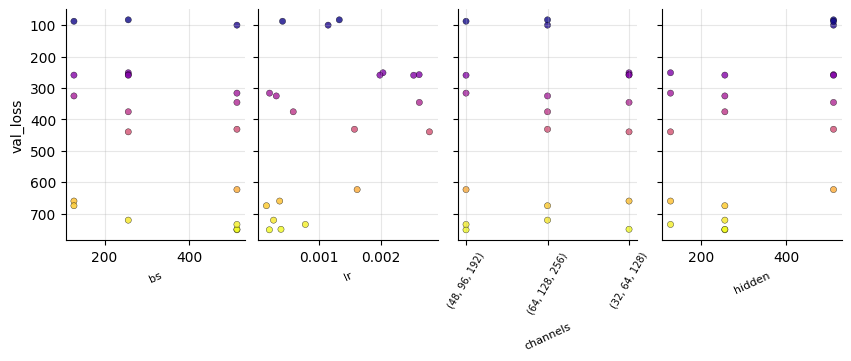

WindowsPath('media/images/1_eyes_explore_scatter.png')

In [4]:
plot_asha_param_grid(analysis, save_path="media/images/1_eyes_explore_scatter.png")

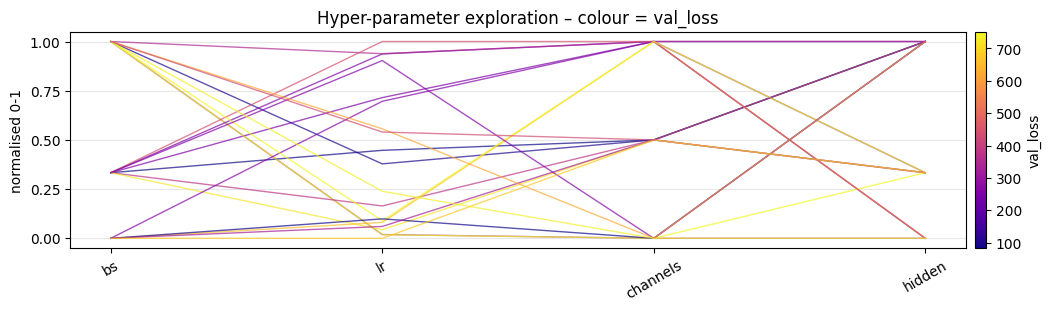

WindowsPath('media/images/1_eyes_explore_parallel.png')

In [5]:
plot_parallel_param_loss(analysis, save_path="media/images/1_eyes_explore_parallel.png")

### Training

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

tune_dir = Path.cwd() / "logs" / "eyes"
best_cfg = get_best_results(latest_tune_dir(tune_dir))
pl.seed_everything(best_cfg["seed"])

dm = GazeDataModule(
    data_dir = Path.cwd() / "data",
    batch_size = best_cfg["bs"],
    img_types = ["l_eye", "r_eye"],
    seed = best_cfg["seed"],
)

model = _build_model(best_cfg, ["l_eye", "r_eye"])

trainer = pl.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices = "auto",
    precision = "bf16-mixed",
    logger = TensorBoardLogger(
        save_dir = Path.cwd() / "logs",
        name     = f"eyes/final/{start_time}",
        log_graph = True,
    ),
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename = "best",
            monitor  = "val_loss",
            mode     = "min",
            save_last = True,
            save_top_k = 1,
        )
    ],
)

trainer.fit(model, datamodule=dm)
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)
model.load_state_dict(state["state_dict"])

out_dir = Path.cwd() / "logs" / "eyes" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

Seed set to 7131
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Best of 'c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\eyes\tune_20250513-201407' ---

Directory: 13f5f_00002
Loss: 83.11
Pixel error: 9.12
Hyperparameters...
- seed: 7131
- bs: 256
- lr: 0.001325325433761898
- channels: [64, 128, 256]
- hidden: 512


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------------------------
0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
3 | rmse      | MeanSquaredError  | 0      | train | ?              | ?             
4 | l_stack   | ConvStack         | 371 K  | train | [1, 3, 64, 64] | [1, 256, 1, 1]
5 | r_stack   | ConvStack         | 371 K  | train | [1, 3, 64, 64] | [1, 256, 1, 1]
6 | regressor | Sequential        | 263 K  | train | [1, 512]       | [1, 2]        
------------------------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.025     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pathlib.WindowsPath was not an allowed global by default. Please use `torch.serialization.add_safe_globals([WindowsPath])` or the `torch.serialization.safe_globals([WindowsPath])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)
model.load_state_dict(state["state_dict"])


out_dir = Path.cwd() / "logs" / "eyes" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

### Model Evaluation

In [10]:
test_results = trainer.test(ckpt_path="best", datamodule=dm)[0]

loss = test_results["test_loss_epoch"]
mae  = test_results["test_mae_epoch"]

# admite ambas variantes por si en otro experimento cambias los flags
mse  = test_results.get("test_mse_epoch",  test_results.get("test_mse"))
rmse = test_results.get("test_rmse_epoch", test_results.get("test_rmse"))

print("────────  Test set  ────────")
print(f"MSE   : {mse:8.2f}  px²")
print(f"RMSE  : {rmse:8.2f}  px")
print(f"MAE   : {mae:8.2f}  px")
print(f"Loss  : {loss:8.2f}  (Smooth-L1)")


Restoring states from the checkpoint path at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\eyes/final/2025-May-13 22-25-01\version_0\checkpoints\best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\.venv\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:200: Could not log computational graph to TensorBoard: The `input_array` or `model.example_input_array` has type <class 'list'> which can't be traced by TensorBoard. Make the input array a tuple representing the positional arguments to the model's `forward()` implementation.
Loaded model weights from the checkpoint at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\eyes/final/2025-May-13 22-25-01\version_0\checkpoints\best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         37.69131851196289
     test_mae_epoch          38.18735122680664
        test_mse              3410.6044921875
        test_rmse           57.935516357421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────  Test set  ────────
MSE   :  3410.60  px²
RMSE  :    57.94  px
MAE   :    38.19  px
Loss  :    37.69  (Smooth-L1)


  0%|          | 0/20077 [00:00<?, ?it/s]

Average error: 52.54px over 2008 samples


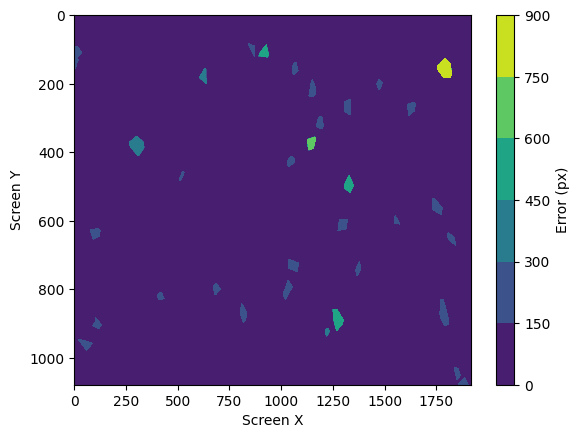

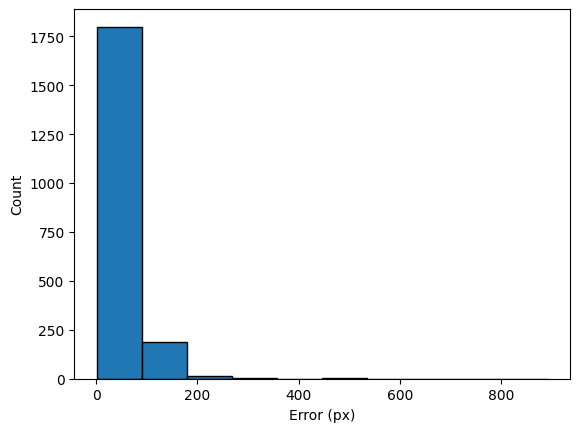

In [ ]:
predict_screen_errors(
    "l_eye",
    "r_eye",
    path_model  = out_dir/"eyetracking_model.pt",
    path_config = out_dir/"eyetracking_config.json",
    path_plot   = out_dir/"error_heatmap_eyes.png",
    path_errors = out_dir/"errors.npy",
    steps       = 10,
)